# **PARKINSON DISEASE PREDICTION**

# ***GAIT ANALYSIS***

In [86]:
import os, zipfile, glob, numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

ZIP_PATH = "/content/Gait.zip"        # your uploaded zip
EXTRACT_DIR = "/content/Gait_unzipped"
MAX_LEN = 12000                       # change if needed (time-steps)
RANDOM_STATE = 42
TEST_SIZE = 0.2

In [87]:
# unzip the data
os.makedirs(EXTRACT_DIR, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    z.extractall(EXTRACT_DIR)
print("Unzipped to:", EXTRACT_DIR)

Unzipped to: /content/Gait_unzipped


In [88]:
#find demographics.txt (search recursively)
demo_paths = glob.glob(os.path.join(EXTRACT_DIR, "**", "demographics.txt"), recursive=True)
if not demo_paths:
    raise FileNotFoundError("demographics.txt not found inside the zip.")
demographics_path = demo_paths[0]
print("Demographics file:", demographics_path)

Demographics file: /content/Gait_unzipped/Gait/demographics.txt


In [89]:
#robustly read demographics (handle tabs/spaces; skip bad lines)
with open(demographics_path,'r') as f:
    header = f.readline().strip()
    # pick separator from header if possible
    cols = header.split('\t') if '\t' in header else header.split()
print("Detected columns:", cols)

df_demo = pd.read_csv(
    demographics_path,
    sep=r'\s+',
    engine='python',
    header=None,
    names=cols,
    skiprows=1,
    on_bad_lines='skip'
)
print("demographics loaded:", df_demo.shape)
print(df_demo.head())

Detected columns: ['ID', 'Study', 'Group', 'Subjnum', 'Gender', 'Age', 'Height', 'Weight', 'HoehnYahr', 'UPDRS', 'UPDRSM', 'TUAG', 'Speed_01', 'Speed_02', 'Speed_03', 'Speed_04', 'Speed_05', 'Speed_06', 'Speed_07', 'Speed_10']
demographics loaded: (166, 20)
       ID Study  Group  Subjnum  Gender  Age  Height  Weight  HoehnYahr  \
0  GaPt03    Ga      1        3       2   82    1.45    50.0        3.0   
1  GaPt04    Ga      1        4       1   68    1.71     NaN        2.5   
2  GaPt05    Ga      1        5       2   82    1.53    51.0        2.5   
3  GaPt06    Ga      1        6       1   72    1.70    82.0        2.0   
4  GaPt07    Ga      1        7       2   53    1.67    54.0        3.0   

   UPDRS  UPDRSM   TUAG  Speed_01  Speed_02  Speed_03  Speed_04  Speed_05  \
0   20.0    10.0  36.34       NaN       NaN       NaN       NaN       NaN   
1   25.0     8.0  11.00     0.642       NaN       NaN       NaN       NaN   
2   24.0     5.0  14.50     0.908       NaN       NaN       

In [90]:
#locate all gait .txt files (exclude demographics.txt)
gait_files = [p for p in glob.glob(os.path.join(EXTRACT_DIR, "**", "*.txt"), recursive=True)
              if os.path.basename(p).lower() != "demographics.txt"]
gait_files = sorted(gait_files)
print(f"Found {len(gait_files)} .txt gait files (first 8):")
print(gait_files[:8])

Found 308 .txt gait files (first 8):
['/content/Gait_unzipped/Gait/GaCo01_01.txt', '/content/Gait_unzipped/Gait/GaCo02_01.txt', '/content/Gait_unzipped/Gait/GaCo02_02.txt', '/content/Gait_unzipped/Gait/GaCo03_01.txt', '/content/Gait_unzipped/Gait/GaCo03_02.txt', '/content/Gait_unzipped/Gait/GaCo04_01.txt', '/content/Gait_unzipped/Gait/GaCo04_02.txt', '/content/Gait_unzipped/Gait/GaCo05_01.txt']


In [91]:
#build label map from demographics: ID -> Group (map Group==1 -> PD, Group==2 -> Control)
label_map = {}
for _, r in df_demo.iterrows():
    sid = str(r.get("ID","")).strip()
    grp = r.get("Group", None)
    if sid=="" or pd.isna(sid): continue
    try:
        # try numeric mapping first
        if int(grp) == 1: label_map[sid] = 1
        elif int(grp) == 2: label_map[sid] = 0
        else:
            # fallback: if group contains text, attempt to map common tokens
            sg = str(grp).lower()
            if 'pd' in sg or 'patient' in sg or 'case' in sg: label_map[sid]=1
            else: label_map[sid]=0
    except Exception:
        sg = str(grp).lower() if not pd.isna(grp) else ""
        label_map[sid] = 1 if ('pd' in sg or 'patient' in sg) else 0

print("Label map size:", len(label_map))
# show sample
list(label_map.items())[:8]

Label map size: 166


[('GaPt03', 1),
 ('GaPt04', 1),
 ('GaPt05', 1),
 ('GaPt06', 1),
 ('GaPt07', 1),
 ('GaPt08', 1),
 ('GaPt09', 1),
 ('GaPt12', 1)]

In [92]:
#helper to load a gait file -> numpy array (time x cols)
def load_gait_file(path):
    try:
        arr = np.loadtxt(path)
        if arr.ndim == 1:
            arr = arr.reshape(1, -1)
        return arr
    except Exception as e:
        # try pandas fallback for irregular separators
        try:
            arr = pd.read_csv(path, header=None, delim_whitespace=True).values
            if arr.ndim == 1: arr = arr.reshape(1, -1)
            return arr
        except Exception:
            print("Could not load:", path, "->", e)
            return None

In [93]:
#iterate files, map labels, keep only sensor columns (drop first column if it's time), pad/truncate
X_list, y_list = [], []
skipped = 0
for p in gait_files:
    fname = os.path.basename(p)
    sid = fname.split("_")[0]   # GaPt03 from GaPt03_04.txt
    lbl = label_map.get(sid, None)
    if lbl is None:
        skipped += 1
        continue
    arr = load_gait_file(p)
    if arr is None:
        skipped += 1
        continue
    # assume first column is time if more than 1 column
    sensors = arr[:,1:] if arr.shape[1] > 1 else arr
    tlen = sensors.shape[0]
    if tlen > MAX_LEN:
        sensors = sensors[:MAX_LEN, :]
    elif tlen < MAX_LEN:
        pad = ((0, MAX_LEN - tlen), (0,0))
        sensors = np.pad(sensors, pad, mode='constant', constant_values=0.0)
    X_list.append(sensors.astype(np.float32))
    y_list.append(int(lbl))

X = np.array(X_list)
y = np.array(y_list)
print(f"Loaded samples: {X.shape}  labels: {y.shape}  skipped files: {skipped}")

if X.size == 0:
    raise RuntimeError("No gait samples loaded. Check naming/ID mapping.")

Loaded samples: (306, 12000, 18)  labels: (306,)  skipped files: 2


In [94]:
#standardization (fit on train later; here fit on entire data then split)
ns, nt, nch = X.shape
X_2d = X.reshape(-1, nch)           # (ns*nt, nch)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_2d).reshape(ns, nt, nch)

In [95]:
#stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train labels counts:", np.bincount(y_train), "Test labels counts:", np.bincount(y_test))

Train: (244, 12000, 18) Test: (62, 12000, 18)
Train labels counts: [ 73 171] Test labels counts: [19 43]


In [96]:
#save prepared arrays for easy reload
OUT = "/content/gait_prepared.npz"
np.savez_compressed(OUT, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, scaler_mean=scaler.mean_, scaler_var=scaler.var_)
print("Saved prepared data to:", OUT)

Saved prepared data to: /content/gait_prepared.npz


In [97]:
#normalisation

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_reshaped = X.reshape(-1, X.shape[-1])  # merge time dimension for scaling
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(X.shape)

In [98]:
#train test split (80-20)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (244, 12000, 18), Test: (62, 12000, 18)


In [99]:
#import libraries

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, LSTM, Bidirectional, BatchNormalization, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import numpy as np

# Early stopping (same for all models)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

# Compute class weights for imbalanced data
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Common training params
EPOCHS = 40
BATCH_SIZE = 8
LR = 0.0007
REG = 0.0005

Class Weights: {0: np.float64(1.6712328767123288), 1: np.float64(0.7134502923976608)}


In [100]:
#define CNN model

model_c = Sequential([
    Conv1D(64, kernel_size=5, activation='relu',
           kernel_regularizer=l2(REG),
           input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),

    Conv1D(128, kernel_size=5, activation='relu', kernel_regularizer=l2(REG)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(REG)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model_c.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [101]:
#define lstm model

model_l = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),
         kernel_regularizer=l2(REG)),
    Dropout(0.4),
    LSTM(64, return_sequences=False, kernel_regularizer=l2(REG)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(REG)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_l.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [102]:
#define bilstm model

model_b = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),
                       kernel_regularizer=l2(REG))),
    Dropout(0.4),
    Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(REG))),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(REG)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_b.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])


In [103]:
#define CNN-LSTM model

model_c_l = Sequential([
    Conv1D(64, kernel_size=5, activation='relu',
           kernel_regularizer=l2(REG),
           input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),

    Conv1D(128, kernel_size=5, activation='relu', kernel_regularizer=l2(REG)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),

    LSTM(64, return_sequences=False, kernel_regularizer=l2(REG)),
    Dropout(0.5),

    Dense(64, activation='relu', kernel_regularizer=l2(REG)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model_c_l.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])


In [104]:
#define CNN-BiLSTM model

model_c_b = Sequential([
    Conv1D(64, kernel_size=3, activation='relu',
           kernel_regularizer=l2(REG),
           input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),

    Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(REG)),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),

    Bidirectional(LSTM(128, return_sequences=False, kernel_regularizer=l2(REG))),
    Dropout(0.5),

    Dense(64, activation='relu', kernel_regularizer=l2(REG)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model_c_b.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])



In [105]:
#train all 5 models

models = {
    "CNN-LSTM": model_c_l,
    "LSTM": model_l,
    "CNN-BiLSTM": model_c_b,
    "CNN": model_c,
    "BiLSTM": model_b
}

histories = {}
results = {}

for name, model in models.items():
    print(f"\nTraining {name} Model...")
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        class_weight=class_weights,
        callbacks=[early_stop],
        verbose=1
    )
    histories[name] = history
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    results[name] = {"Test Accuracy": acc, "Test Loss": loss}
    print(f"{name} Test Accuracy: {acc:.4f} | Test Loss: {loss:.4f}")



Training CNN-LSTM Model...
Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.4042 - loss: 0.8684 - val_accuracy: 0.3878 - val_loss: 0.8844
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.4889 - loss: 0.8810 - val_accuracy: 0.3469 - val_loss: 0.8723
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.5728 - loss: 0.8420 - val_accuracy: 0.6122 - val_loss: 0.8553
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.5553 - loss: 0.8091 - val_accuracy: 0.5714 - val_loss: 0.8647
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.5607 - loss: 0.8408 - val_accuracy: 0.6122 - val_loss: 0.8590
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.5872 - loss: 0.8304 - val_accuracy: 0.6327 - val_loss: 0.8581
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.6677 - loss: 0.7754 - val_accuracy: 0.5918 - val_loss: 0.8445
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.6998 - loss: 0


Evaluating CNN-LSTM Model...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.3750    0.1579    0.2222        19
           1     0.7037    0.8837    0.7835        43

    accuracy                         0.6613        62
   macro avg     0.5394    0.5208    0.5029        62
weighted avg     0.6030    0.6613    0.6115        62



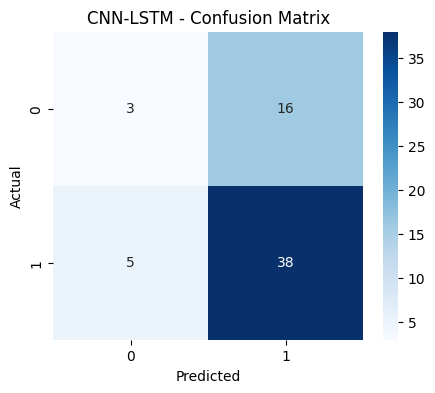

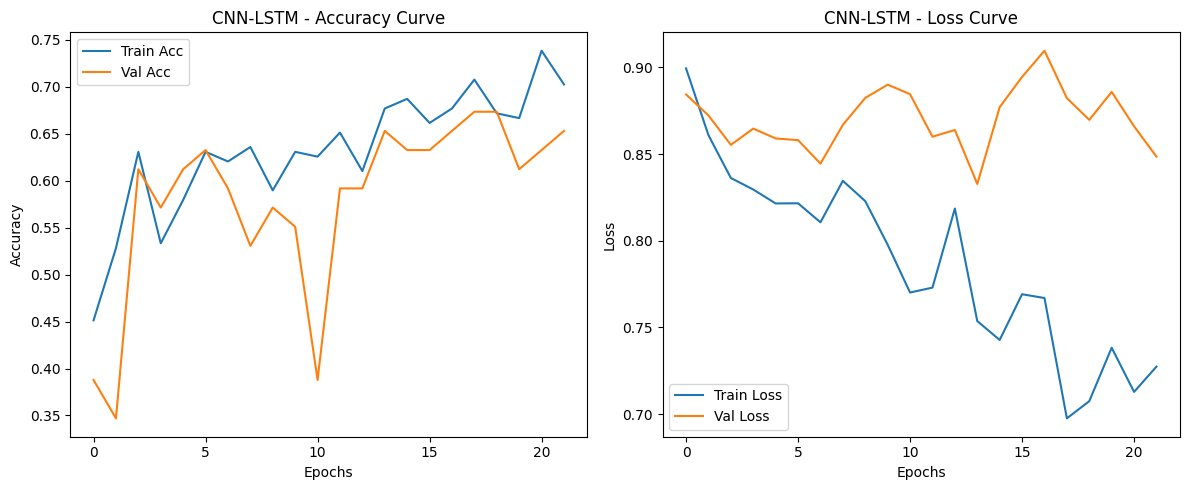


Evaluating LSTM Model...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 398ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.4286    0.1579    0.2308        19
           1     0.7091    0.9070    0.7959        43

    accuracy                         0.6774        62
   macro avg     0.5688    0.5324    0.5133        62
weighted avg     0.6231    0.6774    0.6227        62



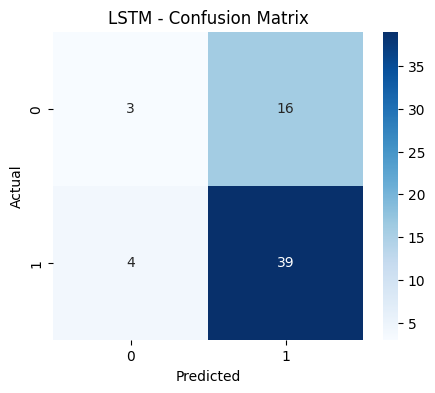

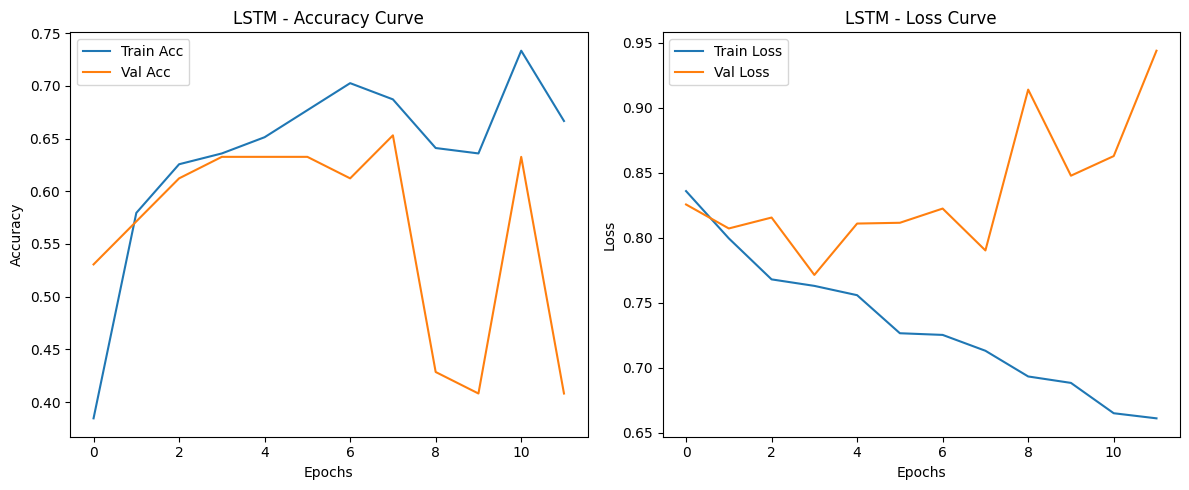


Evaluating CNN-BiLSTM Model...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.3750    0.4737    0.4186        19
           1     0.7368    0.6512    0.6914        43

    accuracy                         0.5968        62
   macro avg     0.5559    0.5624    0.5550        62
weighted avg     0.6260    0.5968    0.6078        62



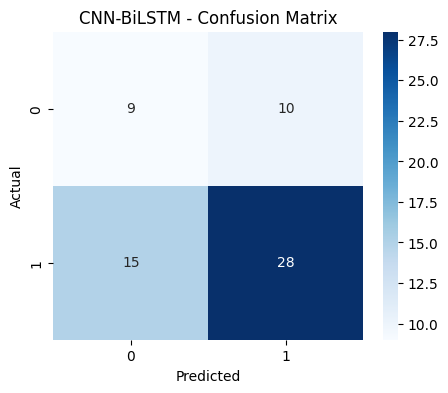

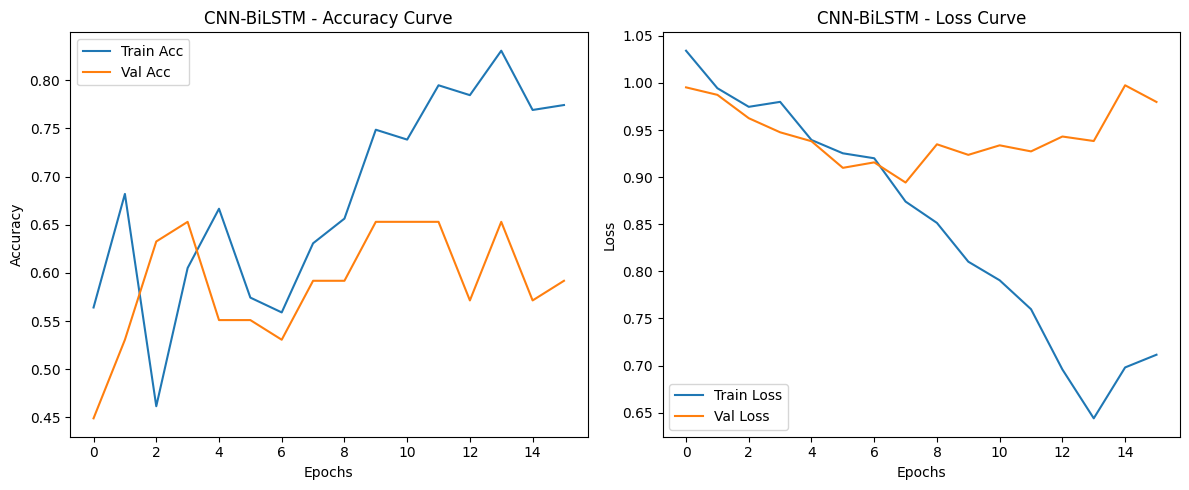


Evaluating CNN Model...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.2500    0.1579    0.1935        19
           1     0.6800    0.7907    0.7312        43

    accuracy                         0.5968        62
   macro avg     0.4650    0.4743    0.4624        62
weighted avg     0.5482    0.5968    0.5664        62



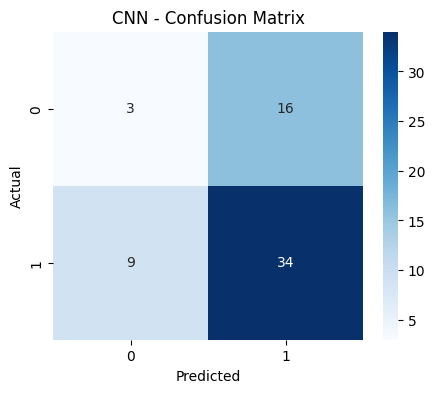

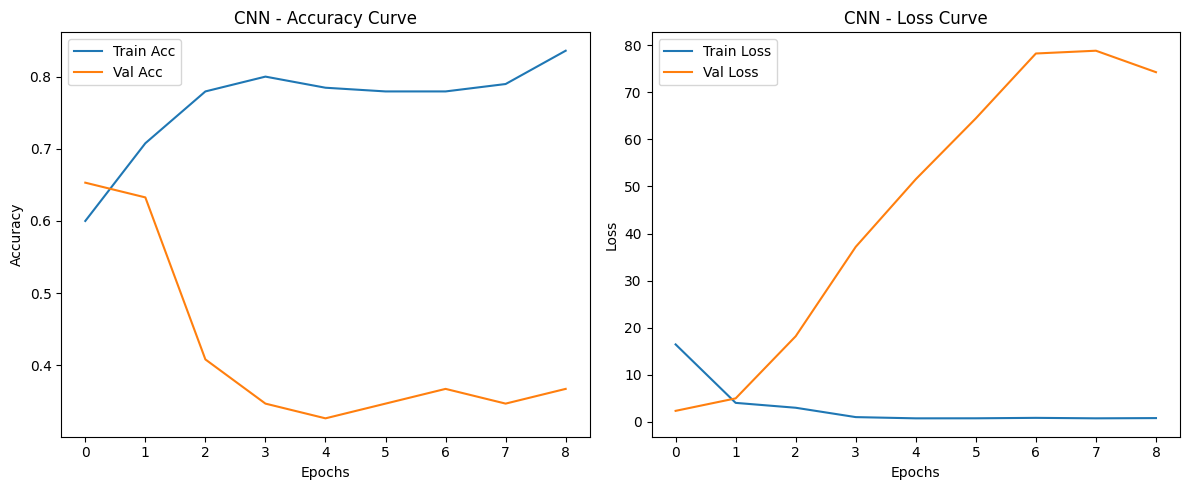


Evaluating BiLSTM Model...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 800ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.5455    0.3158    0.4000        19
           1     0.7451    0.8837    0.8085        43

    accuracy                         0.7097        62
   macro avg     0.6453    0.5998    0.6043        62
weighted avg     0.6839    0.7097    0.6833        62



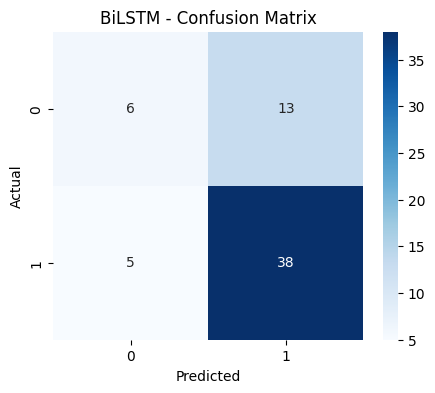

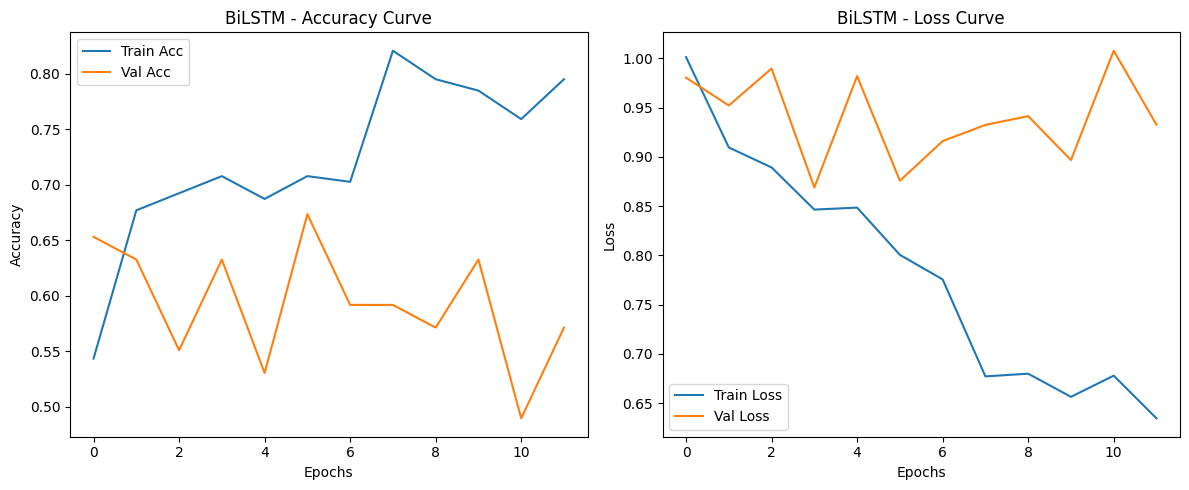


Comparative Evaluation Completed Successfully!


In [106]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Evaluate and visualize results for each model
for name, model in models.items():
    print(f"\nEvaluating {name} Model...")

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).ravel()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # Accuracy & Loss Curves
    history = histories[name]
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title(f'{name} - Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title(f'{name} - Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

print("\nComparative Evaluation Completed Successfully!")


In [107]:
#summary of results

df_results = pd.DataFrame(results).T
print("\nModel Comparison Summary:")
print(df_results)


Model Comparison Summary:
            Test Accuracy  Test Loss
CNN-LSTM         0.661290   0.790038
LSTM             0.677419   0.775376
CNN-BiLSTM       0.596774   0.868397
CNN              0.596774   1.879816
BiLSTM           0.709677   0.836447
